## CNN

In the previous notebook, we trained a neural network to classify heartbeas as normal or abnormal. In this notebook we will take a step further and perform the same task with a CNN to compare results.

CNNs have been well known for their sucess at classification tasks, mainly with images. To use them to classify audio files is necessary to extract audio features in such a way that they meet requirements needed for CNNs. The method is explained by Karol J. Piczak in his paper Environmental sound classification with convolutional neural networks (http://karol.piczak.com/papers/Piczak2015-ESC-ConvNet.pdf). This describes how to get equal size segments from varying length audio clips, and which audio features can be fed into the network as separate channels (akin to RGB channels of colour images).

### Feature Extraction

The idea is to calculate log-scaled mel-spectrograms and their corresponding deltas from a sound clip. Because we need fixed size input, we split each sound clip into 41 overlapping frames, one for each of the 60 mel-bands, giving an array of 60 rows and 41 columns. The mel-spectrogram for each band/segment and its time-series deltas will become two channels, which becomes our input to feed into the CNN. Other features could be calculated in the same way and supplied as a separate input channel, but we'll stick with just the mel-spectragram data for this example.

The feature extraction process is based on example code posted by Aaqib Saeed: http://aqibsaeed.github.io/2016-09-24-urban-sound-classification-part-2/

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd


def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

def extract_features(filename, bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    sound_clip,s = librosa.load(filename)        
    for (start,end) in windows(sound_clip,window_size):
        start = int(start)
        end = int(end)
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
            logspec = librosa.logamplitude(melspec)
            logspec = logspec.T.flatten()[:, np.newaxis].T
            log_specgrams.append(logspec)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features)

Now lets test this method with a sample file

In [2]:
SAMPLE_FILE = os.path.join('data', 'physionet', 'training-a', 'a0001.wav')
features = extract_features(SAMPLE_FILE)
data_points, _ = librosa.load(SAMPLE_FILE)
print ("IN: Initial Data Points =", len(data_points))
print ("OUT: Total features =", np.shape(features))

('IN: Initial Data Points =', 786436)
('OUT: Total features =', (75, 60, 41, 2))


Its important to point out that this method outputs a feature representation bigger than the previous method used for the FFN. For the same file this method has reduced the input from 786436 features to 369000 compared to the previous 193 features. By having more information it is expected to have better results.

Let's proceed with the rest of the dataset.

In [2]:
def parse_files(subdirs):
    parent_dir = os.path.join('data', 'physionet')
    save_path = os.path.join('data', 'physionet', 'reduced_features')
    bands = 60
    frames = 41
    window_size = 512 * (frames - 1)
    for path, df_name in paths:
        log_specgrams = []
        labels = []
        csv_path = os.path.join(path, 'REFERENCE.csv')
        df = pd.read_csv(csv_path, names = ['fname', 'target'])
        df['fname'] = df['fname'].apply(lambda f: os.path.join(path,f + '.wav'))
        df['target'] = df['target'].apply(lambda x: 1 if x == -1 else 0)
        for index, row in df.iterrows():
            sound_clip,s = librosa.load(row['fname'])
            label = row['target']
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == int(window_size)):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
        log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
        features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
        for i in range(len(features)):
            features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
        feature_file = os.path.join(save_path, df_name + '_cnn_x.npy')
        np.save(feature_file, np.array(features))
        feature_file = os.path.join(save_path, df_name + '_cnn_y.npy')
        np.save(feature_file, np.array(labels))

In [3]:
paths = [(os.path.join('data', 'physionet', 'training-a'), 'df_a'),
         (os.path.join('data', 'physionet', 'training-b'), 'df_b'), 
         (os.path.join('data', 'physionet', 'training-c'), 'df_c'),
         (os.path.join('data', 'physionet', 'training-d'), 'df_d'),
         (os.path.join('data', 'physionet', 'training-e'), 'df_e')]

# Uncomment line below to parse all files.
# parse_files(paths)

I have included a subset of the parsed files at the repo in order to test the CNN. The complete dataset for this part measures about 5GB uncompressed. To test the CNN with the full dataset will require to parse all files locally, which will take some time.

In [4]:
# Uncomment this to use subset found at repo.
# npfiles = [('df_a_cnn_x.npy','df_a_cnn_y.npy'),
#           ('df_b_cnn_x.npy','df_b_cnn_y.npy'),
#           ('df_c_cnn_x.npy','df_c_cnn_y.npy'),
#           ('df_d_cnn_x.npy','df_d_cnn_y.npy')]

npfiles = [('df_a_cnn_x.npy','df_a_cnn_y.npy'),
           ('df_b_cnn_x.npy','df_b_cnn_y.npy'),
           ('df_c_cnn_x.npy','df_c_cnn_y.npy'),
           ('df_d_cnn_x.npy','df_d_cnn_y.npy'),
           ('df_e_cnn_x.npy','df_e_cnn_y.npy')]

data_dir = os.path.join('data', 'physionet', 'reduced_features')

def load_npfiles(npfiles):
    concatenate = False
    for x, y in npfiles:
        print("Adding X:", x)
        loaded_features = np.load(os.path.join(data_dir, x))
        print("Shape X:", loaded_features.shape)

        print("Adding y:", y)
        loaded_labels = np.load(os.path.join(data_dir, y))
        print("Shape Y:", loaded_labels.shape)

        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

Adding X: df_a_cnn_x.npy
Shape X: (28071, 60, 41, 2)
Adding y: df_a_cnn_y.npy
Shape Y: (28071,)
Adding X: df_b_cnn_x.npy
Shape X: (7815, 60, 41, 2)
Adding y: df_b_cnn_y.npy
Shape Y: (7815,)
Adding X: df_c_cnn_x.npy
Shape X: (3251, 60, 41, 2)
Adding y: df_c_cnn_y.npy
Shape Y: (3251,)
Adding X: df_d_cnn_x.npy
Shape X: (1712, 60, 41, 2)
Adding y: df_d_cnn_y.npy
Shape Y: (1712,)
Adding X: df_e_cnn_x.npy
Shape X: (103175, 60, 41, 2)
Adding y: df_e_cnn_y.npy
Shape Y: (103175,)


### Training

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [19]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
import keras.backend as K

def create_model(dropout_rate=0.5):
    frames = 41
    bands = 60
    feature_size = bands * frames
    num_channels = 2
    f_size = 1
    model = Sequential()
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same', input_shape=(bands, frames, num_channels)))
    model.add(Convolution2D(48, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Convolution2D(96, f_size, strides=f_size, kernel_initializer='normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
model = create_model()

In [8]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Train on 108018 samples, validate on 36006 samples
Epoch 1/25
108018/108018 [==============================] - 97s - loss: 0.3027 - acc: 0.8588 - val_loss: 0.2355 - val_acc: 0.8963
Epoch 2/25
108018/108018 [==============================] - 73s - loss: 0.2293 - acc: 0.8989 - val_loss: 0.1912 - val_acc: 0.9130
Epoch 3/25
108018/108018 [==============================] - 73s - loss: 0.1971 - acc: 0.9135 - val_loss: 0.1815 - val_acc: 0.9203
Epoch 4/25
108018/108018 [==============================] - 73s - loss: 0.1803 - acc: 0.9204 - val_loss: 0.1746 - val_acc: 0.9209
Epoch 5/25
108018/108018 [==============================] - 73s - loss: 0.1703 - acc: 0.9256 - val_loss: 0.1734 - val_acc: 0.9217
Epoch 6/25
108018/108018 [==============================] - 73s - loss: 0.1608 - acc: 0.9289 - val_loss: 0.1670 - val_acc: 0.9274
Epoch 7/25
108018/108018 [==============================] - 73s - loss: 0.1543 - acc: 0.9323 - val_loss: 0.1722 - val_acc: 0.9240
Epoch 8/25
108018/108018 [=============

Saving the model

In [9]:
model.save_weights('models/cnn.hdf5')

### Results

Lets display the curves of loss and accuracy during training

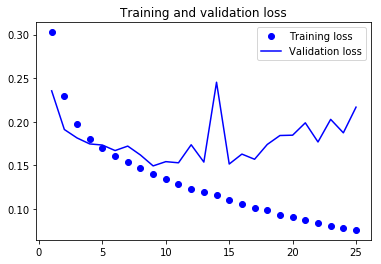

In [10]:
epochs = range(1, 26)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

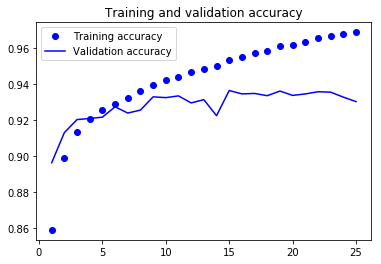

In [11]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

From the graphs we can observe that accuracy of the model does not increases after the 10th epoch.

In [12]:
model.load_weights('models/cnn.hdf5')

In [14]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict_classes(x_test)

    score, accuracy = model.evaluate(x_test, y_test, batch_size=32)
    print("\nAccuracy:", accuracy)

    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Precision:", p)
    print("Recall:", r)
    print("F-Score:", f1)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
evaluate(model, x_test, y_test)

35744/36006 [============================>.] - ETA: 0s
Accuracy: 0.930317169361
Precision: 0.949037534374
Recall: 0.960876482499
F-Score: 0.954920315504
Confusion Matrix:
[[ 6923  1427]
 [ 1082 26574]]


### Refinement

As same as we did with the FFN to use GridSearch to find a set of hyperparameters that would generate the best model, we will use the same method with the CNN. Because of the time required to train the CNN in this part we will only experiment with the dropout rate. The same method can be applied to different parameters but it will require the signature of the function to create the model to match with what will be used in the GridSearch.

In [20]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model)

dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]

param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1')

grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Epoch 1/10
72012/72012 [==============================] - 45s - loss: 0.3191 - acc: 0.8442    
Epoch 2/10
72012/72012 [==============================] - 45s - loss: 0.2519 - acc: 0.8844    
Epoch 3/10
72012/72012 [==============================] - 45s - loss: 0.2232 - acc: 0.9004    
Epoch 4/10
72012/72012 [==============================] - 45s - loss: 0.1983 - acc: 0.9119    
Epoch 5/10
72012/72012 [==============================] - 45s - loss: 0.1815 - acc: 0.9201    
Epoch 6/10
72012/72012 [==============================] - 45s - loss: 0.1703 - acc: 0.9259    
Epoch 7/10
72012/72012 [==============================] - 45s - loss: 0.1611 - acc: 0.9302    
Epoch 8/10
72012/72012 [==============================] - 45s - loss: 0.1524 - acc: 0.9346    
Epoch 9/10
72012/72012 [==============================] - 45s - loss: 0.1465 - acc: 0.9366    
Epoch 10/10
72012/72012 [==============================] - 45s - loss: 0.3185 - acc: 0.8472    
Epoch 2/10
72012/72012 [=========================

72012/72012 [==============================] - 45s - loss: 0.2501 - acc: 0.8865    
Epoch 3/10
72012/72012 [==============================] - 45s - loss: 0.2117 - acc: 0.9061    
Epoch 4/10
72012/72012 [==============================] - 45s - loss: 0.1882 - acc: 0.9173    
Epoch 5/10
72012/72012 [==============================] - 45s - loss: 0.1720 - acc: 0.9243    
Epoch 6/10
72012/72012 [==============================] - 45s - loss: 0.1632 - acc: 0.9288    
Epoch 7/10
72012/72012 [==============================] - 45s - loss: 0.1531 - acc: 0.9331    
Epoch 8/10
72012/72012 [==============================] - 45s - loss: 0.1442 - acc: 0.9362    
Epoch 9/10
72012/72012 [==============================] - 45s - loss: 0.1370 - acc: 0.9414    
Epoch 10/10
72012/72012 [==============================] - 46s - loss: 0.3211 - acc: 0.8455    
Epoch 2/10
72012/72012 [==============================] - 45s - loss: 0.2564 - acc: 0.8836    
Epoch 3/10
72012/72012 [==============================] - 45

Now that we have the best value for the dropout rate lets use that to train a model. Also, from the first model we observed that after the 10th epoch the accuracy of the model did not improve, so we will use that value to train this model as well.

In [22]:
model = create_model(dropout_rate=0.4)

In [23]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Train on 108018 samples, validate on 36006 samples
Epoch 1/10
108018/108018 [==============================] - 75s - loss: 0.3003 - acc: 0.8581 - val_loss: 0.2245 - val_acc: 0.8982
Epoch 2/10
108018/108018 [==============================] - 74s - loss: 0.2263 - acc: 0.8971 - val_loss: 0.2227 - val_acc: 0.8984
Epoch 3/10
108018/108018 [==============================] - 75s - loss: 0.1956 - acc: 0.9132 - val_loss: 0.1869 - val_acc: 0.9169
Epoch 4/10
108018/108018 [==============================] - 74s - loss: 0.1792 - acc: 0.9202 - val_loss: 0.1732 - val_acc: 0.9241
Epoch 5/10
108018/108018 [==============================] - 74s - loss: 0.1696 - acc: 0.9248 - val_loss: 0.1656 - val_acc: 0.9253
Epoch 6/10
108018/108018 [==============================] - 74s - loss: 0.1616 - acc: 0.9296 - val_loss: 0.1721 - val_acc: 0.9255
Epoch 7/10
108018/108018 [==============================] - 74s - loss: 0.1546 - acc: 0.9324 - val_loss: 0.1624 - val_acc: 0.9283
Epoch 8/10
108018/108018 [=============

In [24]:
model.save_weights('models/cnn_best.hdf5')

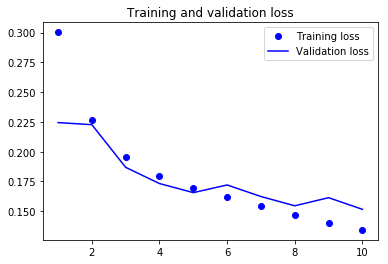

In [25]:
epochs = range(1, 11)
plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

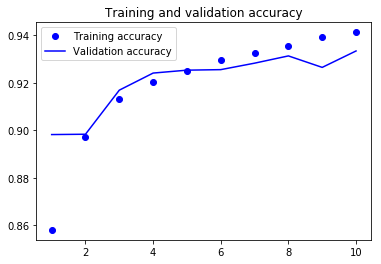

In [26]:
plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [27]:
evaluate(model, x_test, y_test)

36006/36006 [==============================] - 6s     

Accuracy: 0.933399988891
Precision: 0.962228240978
Recall: 0.950607463118
F-Score: 0.956382553021
Confusion Matrix:
[[ 7318  1032]
 [ 1366 26290]]


From the results above we can observe that the results did not improve by much, but we will still use this model in the next notebook.